In [4]:
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from lcvae import LCVAE
from sklearn.metrics import accuracy_score

# ==========================
# Load the test data
# ==========================
data = pd.read_csv("./dataset/kdd_full_clean_5classes.csv")
X = data.drop(columns=["target"])
y = data["target"]

# Load transformer and encode features
tdt = joblib.load("./typed_nslkdd_all_features.pkl")
X_encoded = tdt.transform(data)

# Train/test split
_, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

# Encode labels to integers
encoder_label = LabelEncoder()
y_test_encoded = encoder_label.fit_transform(y_test)

# ==========================
# Reload model
# ==========================
latent_dim = 128
n_classes = len(np.unique(y_test_encoded))
input_dim = X_test.shape[1]
batch_size = 10000

# Recreate the model architecture
model = LCVAE(
    input_dim=input_dim,
    latent_dim=latent_dim,
    n_classes=n_classes,
    lambda_kl=0.05,
    k=40,
    batch_size=batch_size
)

# Build the model by calling it once
_ = model(tf.convert_to_tensor(X_test[:1], dtype=tf.float32))
model.load_weights("./models_training/lcvae_weights_nsl.weights.h5", skip_mismatch=True)



# ==========================
# Helper function to make batch predictions
# ==========================
def predict_in_batches(model, data, batch_size):
    """
    Predicts in batches, handling variable batch sizes at the end.
    """
    all_means, all_log_vars, all_preds = [], [], []
    for i in tqdm(range(0, len(data), batch_size)):
        batch = data[i:i+batch_size]
        # Ensure batch is float32 tensor
        batch_tensor = tf.convert_to_tensor(batch, dtype=tf.float32)
        _, mean, log_var, z = model(batch_tensor, training=False)
        all_means.append(mean.numpy())
        all_log_vars.append(log_var.numpy())
        all_preds.append(z.numpy())
    return (
        np.concatenate(all_means, axis=0),
        np.concatenate(all_log_vars, axis=0),
        np.concatenate(all_preds, axis=0)
    )

# ==========================
# Run evaluation
# ==========================
# Use the full test set, even if the last batch is smaller
X_test_batch = X_test
y_test_batch = y_test_encoded

# Predict mean, logvar and latent vectors in batches
mean_pred, log_var_pred, latent_vectors = predict_in_batches(
    model, X_test_batch, batch_size=batch_size
)

print(f"Shape of latent vectors: {latent_vectors.shape}")
print(f"Shape of Y_test: {y_test_batch.shape}")

# Ensure matching size
if len(y_test_batch) != len(latent_vectors):
    y_test_batch = y_test_batch[:len(latent_vectors)]


/home/zamaien/esorics/NSLKDD/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:629: UserWarning: A total of 1 objects could not be loaded. Example error message for object <LCVAE name=lcvae_3, built=True>:

Layer 'lcvae_3' expected 0 variables, but received 1 variables during loading. Expected: []

List of objects that could not be loaded:
[<LCVAE name=lcvae_3, built=True>]
  warnings.warn(msg)
100%|██████████| 5/5 [00:00<00:00, 13.25it/s]

Shape of latent vectors: (44556, 128)
Shape of Y_test: (44556,)


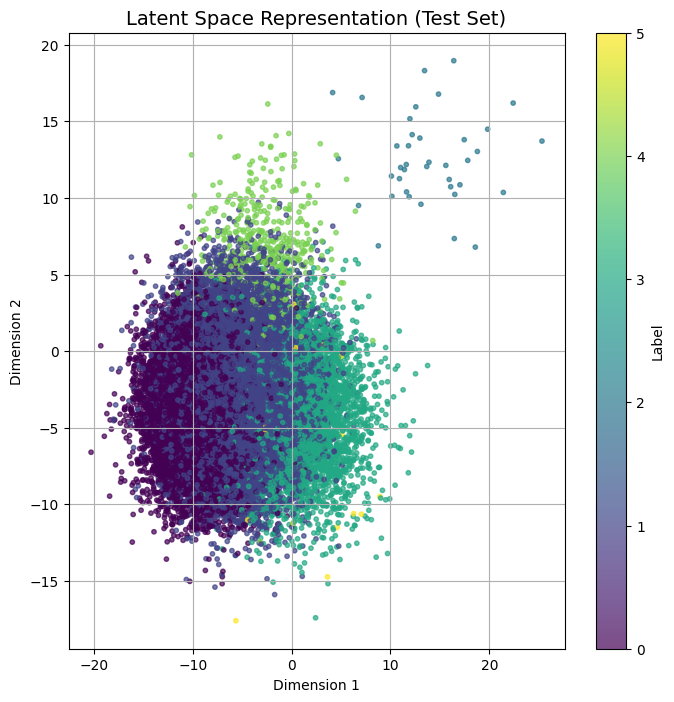

In [5]:
# ==========================
# Visualize latent space (2D only)
# ==========================
#if latent_vectors.shape[1] == 2:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    latent_vectors[:, 0], latent_vectors[:, 1], 
    c=y_test_batch.astype(int), cmap='viridis', s=10, alpha=0.7
)
plt.colorbar(scatter, label='Label')
plt.title('Latent Space Representation (Test Set)', fontsize=14)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()
#else:
#    print("Latent space visualization skipped: dimensionality != 2")

In [6]:
# ==========================
# Generate synthetic data from clusters
# ==========================
def generate_latent_points_batched(class_distribution, center_cluster, sigma2_per_class,
                                    epsilon=1.0, batch_size=10000, seed=42, dtype=np.float32):
    np.random.seed(seed)
    z_list = []
    y_list = []
    for label, count in class_distribution.items():
        mean = center_cluster[label].astype(dtype)
        stddev = (np.sqrt(sigma2_per_class[label]) * epsilon).astype(dtype)
        latent_dim = len(mean)
        for i in tqdm(range(0, count, batch_size)):
            n = min(batch_size, count - i)
            samples = np.random.randn(n, latent_dim).astype(dtype) * stddev + mean
            z_list.append(samples)
            y_list.append(np.full(n, label, dtype=int))
    z = np.concatenate(z_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return z, y


In [10]:
# Generate latent vectors
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
sigma_cluster = np.load("./models_training/sigma_per_class_nsl.npy")
cluster_centers = np.load("./models_training/cluster_centers_nsl.npy")

z, y_gen = generate_latent_points_batched(
    class_distribution=class_distribution,
    center_cluster=cluster_centers,
    sigma2_per_class=sigma_cluster,
    epsilon=1.75,          
    batch_size=batch_size
)

def decode_generated_batches(decode_fn, data, batch_size):
    results = []
    for i in tqdm(range(0, len(data), batch_size), desc="Décodage VAE en batch"):
        batch = data[i:i+batch_size]
        batch_tensor = tf.convert_to_tensor(batch, dtype=tf.float32)
        pred = decode_fn(batch_tensor)
        results.append(pred.numpy())
    return np.concatenate(results, axis=0)

generation_decod_vae = decode_generated_batches(model.decode, z, batch_size=batch_size)

Generation_real = tdt.inverse_transform(generation_decod_vae)
Generation_real['target'] = y_gen

print("Dataframe générée:", Generation_real.shape)
Generation_real.head()
Generation_real.to_csv("./generations_nsl/cluster_vae_df.csv", index=False)


Décodage VAE en batch: 100%|██████████| 11/11 [00:00<00:00, 31.64it/s]


Dataframe générée: (103961, 42)


In [9]:
unique, counts = np.unique(y_gen, return_counts=True)
print(unique)
print(counts)

[0 1 2 3 4 5]
[37749 55011    95  9669  1374    63]


In [ ]:
import numpy as np
sigma_cluster = np.load("./models_training/sigma_per_class_30epochs.npy")
print(sigma_cluster)

[[ 8.716008   9.062944  13.912105   7.7177076  9.499852   9.353711
   7.997971  10.007453   8.9887    10.617986   8.553486   8.642532
   7.983366   8.955295   8.576553   9.680981   8.016698   9.742918
   8.502817   9.264836   8.203033  10.016867  11.170691   8.382718
   9.064745  10.989345  10.385125   9.375714  10.956994   8.754864
   9.720874   8.981214   9.441128  11.606768  11.626623  10.897407
   8.985571  12.088617  12.403266  13.396092   8.1050625 13.7508545
  12.991872   9.9268465 13.0914135  8.754641  11.803935  10.828905
   8.056008  10.937483  12.069345  10.981113   9.851054   9.702561
   9.041396  12.47638   11.054512   9.041141   9.379246   8.0192
   8.40283    8.111226  13.699323  11.052786   8.650879   9.893868
  10.169065  11.56718   10.640556  12.656025   9.703554  12.503085
   9.066046  10.770722  12.144969  13.181888  10.756664  10.3206
  10.616275   9.0030155  8.003171   8.623015   8.092378  12.245181
   8.739706  11.698029   8.887269  11.150179  10.0615425  8.80580